## Requirements

In [1]:
import collections
import itertools
import matplotlib.pyplot as plt
import random
import timeit
import typing

## Problem setting

Consider a database consisting of intervals over the positive integers, i.e., each element in the database is a half-open interval $d_i = [d_{i,s}, d_{i,e})$.  The database can be represented as $D = \{d_i | i \in [0, M)\}$, so $|D| = M$.  Clearly, for each interval $d_i$, $d_{i,e} > d{i, s} + 1$.

An intersection query is based on a query interval $q = [q_s, q_e)$ with $q_e > q_s + 1$; the query returns all intervals in $D$ that query interval intersects, i.e.,
$$
  \{ d | d \in D \wedge q_s < d_e \wedge d_s < q_e\}
$$

Rather than querying for a single interval, $N$ intervals are queried, the set of query intervals is denoted by $Q$.  The result of such a query is given by
$$
  \{(q, d) | (q, d) \in Q \times D \wedge q_s < d_e \wedge d_s < q_e\}
$$

## Database and queries

Define some type aliases to give more structure to the code.

In [2]:
Interval = collections.namedtuple('Interval', ('s', 'e'))
Db: typing.TypeAlias = set[Interval]
Queries: typing.TypeAlias = Db
QueryResult: typing.TypeAlias = set[tuple[Interval, Interval]]

First, generate the database.

In [3]:
def generate_interval(max_end: int = 1_000_000_000) -> Interval:
    '''Generate a half-open interval of at least length 1
    
    Parameters
    ----------
    max_end: int
        largest end value of the interval, default value 1_000_000_000
        
    Returns
    -------
    Interval
        Tuple (start, end) such that end - start > 1
    '''
    start = random.randint(0, max_end - 2)
    end = random.randint(start + 2, max_end)
    return Interval(s=start, e=end)

In [4]:
def create_db(size: int = 1_000, max_end: int = 1_000_000) -> Db:
    '''Generate a database of intervals
    
    Parameters
    ----------
    size: int
        number of intervals in the database, default value 1_000
    max_end: int
        largest end value of the interval, default value 1_000_000_000

    Returns
    -------
    Db
        a set of half-open intervals

    Note
    ----
    The database may contain less than the specified number of intervals if the same interval is generated multiple times.
    '''
    return {generate_interval(max_end) for _ in range(size)}

In [5]:
def create_queries(size: int = 1_000, max_end: int = 1_000_000) -> Queries:
    '''Generate query intervals
    
    Parameters
    ----------
    size: int
        number of intervals in the query, default value 1_000
    max_end: int
        largest end value of the interval, default value 1_000_000_000

    Returns
    -------
    Queries
        a set of half-open intervals

    Note
    ----
    The queries may contain less than the specified number of intervals if the same interval is generated multiple times.
    '''
    return create_db(size=size, max_end=max_end)

In [6]:
create_db(size=10, max_end=100)

{Interval(s=4, e=58),
 Interval(s=17, e=60),
 Interval(s=19, e=57),
 Interval(s=25, e=47),
 Interval(s=33, e=55),
 Interval(s=44, e=92),
 Interval(s=61, e=72),
 Interval(s=82, e=98),
 Interval(s=89, e=98),
 Interval(s=92, e=94)}

For benchmarking, these parameters are used.

In [17]:
sizes = [2**i for i in range(7, 14)]
nr_repeats = 5

## Naive approach

A very simple but naive approach is to check overlap of each query interval with every database interval resulting in $|Q| \times |D|$ queries>

In [18]:
def have_intersection(q: Interval, d: Interval) -> bool:
    '''Check whether two intervals intersect
    
    Parameters
    ----------
    q, d: Interval
        intervals to check intersection for
        
    Returns
    -------
    bool
        True if q and d intersect, False otherwise
    '''
    return q.s < d.e and d.s < q.e

In [19]:
def execute_queries(queries: Queries, db: Db) -> QueryResult:
    '''Execute the query on the database

    Parameters
    ----------
    queries: Queries
        queries to be executed
    db: Db
        database to query

    Returns
    -------
    QueryResult
        set of tuples of query and database intervals that intersect
    '''
    return {(q, d) for q, d in itertools.product(queries, db) if have_intersection(q, d)}

In [20]:
random.seed(1234)
naive_times = [
    timeit.repeat(
        stmt='execute_queries(queries, db)',
        setup=f'queries, db = create_queries({size}), create_db({size})',
        repeat=nr_repeats,
        number=1,
        globals=globals(),
    ) for size in sizes
]

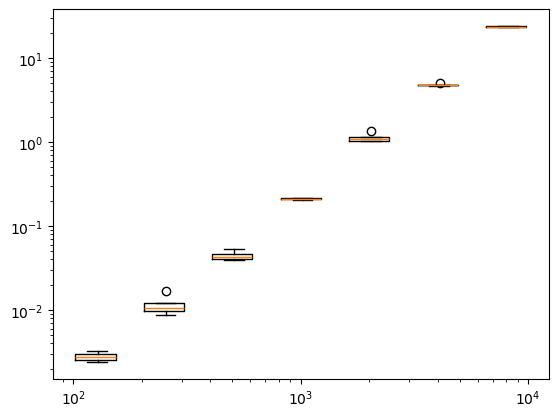

In [21]:
plt.boxplot(naive_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.xscale('log')
plt.yscale('log');

The time complexity of this algorithm is $N^2$ for $|D| = |Q| = N$.